## Loading our BERT model trained on Litcovid

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
DATA_AND_BERT_FOLDER = '/content/drive/MyDrive/PSTALN/'

In [2]:
!pip install -q transformers

# Importing stock ml libraries
import pickle
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

     |████████████████████████████████| 1.5MB 7.8MB/s 
     |████████████████████████████████| 2.9MB 40.3MB/s 
     |████████████████████████████████| 890kB 52.6MB/s 
cuda


In [3]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        for param in self.l1.parameters():
         param.requires_grad = False
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 9)
    
    def forward(self, ids, mask, token_type_ids):
        output1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output1[1])
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [7]:
if torch.cuda.is_available():
  model.load_state_dict(torch.load(DATA_AND_BERT_FOLDER+'BERT_litcovid.pt'))
else:
  model.load_state_dict(torch.load(DATA_AND_BERT_FOLDER++'BERT_litcovid.pt', map_location=torch.device('cpu')))

## Loading our data

In [8]:
a = pd.read_pickle(DATA_AND_BERT_FOLDER+'clean_df_bibliovid_pretreated.pkl')

In [9]:
b = a[['cat_text', 'vect_specs', 'input_ids', 'attention_mask', 'token_type_ids']]
b

,cat_text,vect_specs,input_ids,attention_mask,token_type_ids
0,Body Mass Index and Risk for Intubation or Dea...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[101, 2303, 3742, 5950, 3891, 20014, 19761, 35...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,An mRNA Vaccine against SARS-CoV-2 - Prelimina...,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 28848, 17404, 18906, 9363, 2615, 2475, 8...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"Pathophysiology, Transmission, Diagnosis, and ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[101, 4130, 7361, 10536, 20763, 6483, 6726, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Introductions and Early Spread of SARS-CoV-2 i...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[101, 25795, 2220, 3659, 18906, 9363, 2615, 24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,How to Safely Reopen Colleges and Universities...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[101, 9689, 2128, 26915, 6667, 5534, 2522, 172...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
366,Safety and efficacy of different anesthetic re...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[101, 3808, 21150, 2367, 2019, 4355, 20086, 69...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
367,A systematic review on the efficacy and safety...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[101, 11778, 3319, 21150, 3808, 10381, 10626, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
368,Detection of Novel Coronavirus by RT-PCR in St...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[101, 10788, 3117, 21887, 23350, 19387, 15042,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
369,The effect of travel restrictions on the sprea...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[101, 3466, 3604, 9259, 3659, 10476, 16693, 28...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [35]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 3e-5 #conseillé sur le papier
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [36]:
class CustomDataset(Dataset):

    def __init__(self, dataframe):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.comment_text = dataframe.cat_text
        self.targets = self.data.vect_specs
        self.input_ids=[]
        self.attention_mask=[]
        self.token_type_ids=[]
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):
        self.input_ids=self.data.input_ids.iloc[index]
        self.attention_mask=self.data.attention_mask.iloc[index]
        self.token_type_ids=self.data.token_type_ids.iloc[index]
        return {
            'ids': torch.tensor(self.input_ids, dtype=torch.long),
            'mask': torch.tensor(self.attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(self.token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [37]:
# Creating the dataset and dataloader for the neural network

train_size = 0.7
valid_size = 0.2

train_dataset = b.sample(frac=train_size,random_state=200)
valid_dataset = b.drop(train_dataset.index)
train_dataset = train_dataset.reset_index(drop=True)

valid_bck = valid_dataset

valid_dataset=valid_bck.sample(frac=1 - valid_size/train_size,random_state=200)
test_dataset=valid_bck.drop(valid_dataset.index).reset_index(drop=True)
valid_dataset = valid_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(b.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("VALID Dataset: {}".format(valid_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(train_dataset)
valid_set = CustomDataset(valid_dataset)
testing_set = CustomDataset(test_dataset)

FULL Dataset: (371, 5)
TRAIN Dataset: (260, 5)
VALID Dataset: (79, 5)
TEST Dataset: (32, 5)


In [38]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(valid_set, **valid_params)
testing_loader = DataLoader(testing_set, **test_params)

data_loaders = {'train':training_loader, 'valid':validation_loader}

## Training and testing

Changing the number of outputs of the model

In [39]:
if torch.cuda.is_available():
  model.l3 = torch.nn.Linear(768, 17).cuda()
else:
  model.l3 = torch.nn.Linear(768, 17)

In [40]:
def model_parameters_number(model):
  l=[]
  for parameter in model.parameters():
      l.append(parameter)
  s=0
  for el in l:
    try :s+=el.shape[0]*el.shape[1]
    except: s+=el.shape[0]
  return s
model_parameters_number(model)

109495313

In [41]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

Freezing the weights we want

In [42]:
freezing_weights = True

if freezing_weights:
  trainable_parameters = []
  for name, p in model.named_parameters():
      if 'l3' not in name: #or 'pooler' not in name:
          p.requires_grad = False
          trainable_parameters.append(p)

  optimizer = torch.optim.Adam(params=trainable_parameters, lr=LEARNING_RATE)

else:
  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [43]:
def train(epochs):
    train_losses = []
    valid_losses = []
    # model.train()
    for epoch in range(epochs):
      for phase in ['train', 'valid']:
        if phase == 'train':
            print()
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        for _,data in enumerate(data_loaders[phase]):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)

            optimizer.zero_grad()
            loss = loss_fn(outputs, targets)

            # Uncomment if you want the training accuracy

            # accuracy_list = []
            # thresholds = np.arange(0.2,0.7,0.05)
            # targets_cpu = targets.cpu()
            # for limit in thresholds:
            #   outputs_bin = outputs.cpu().detach().numpy() >= limit
            #   accuracy_list.append(metrics.accuracy_score(targets_cpu, outputs_bin))
            # limit_chosen = round(thresholds[np.argmax(accuracy_list)], 2)
            # outputs_acc = outputs.cpu().detach().numpy() >= limit_chosen
            # train_accuracy = metrics.accuracy_score(targets_cpu, outputs_acc)

            if _%len(training_loader)==0:
                print(f'Epoch: {epoch}, {phase} Loss:  {loss.item()}')
                if phase == 'train':
                  valid_losses.append(loss)
                else:
                  train_losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
    plt.plot(train_losses, 'r', label='Training Loss')
    plt.plot(valid_losses, 'b', label='Validation Loss')
    plt.legend()


Epoch: 0, train Loss:  0.6930502653121948
Epoch: 0, valid Loss:  0.6878674626350403

Epoch: 1, train Loss:  0.7037177085876465
Epoch: 1, valid Loss:  0.6855139136314392

Epoch: 2, train Loss:  0.6989275813102722
Epoch: 2, valid Loss:  0.6941601037979126

Epoch: 3, train Loss:  0.7073431015014648
Epoch: 3, valid Loss:  0.6866655945777893

Epoch: 4, train Loss:  0.6916708946228027
Epoch: 4, valid Loss:  0.6923936009407043

Epoch: 5, train Loss:  0.6922999024391174
Epoch: 5, valid Loss:  0.7005046606063843

Epoch: 6, train Loss:  0.7069517374038696
Epoch: 6, valid Loss:  0.6895201206207275

Epoch: 7, train Loss:  0.6969218850135803
Epoch: 7, valid Loss:  0.6996172666549683

Epoch: 8, train Loss:  0.708674967288971
Epoch: 8, valid Loss:  0.684004008769989

Epoch: 9, train Loss:  0.6837186813354492
Epoch: 9, valid Loss:  0.6910924315452576

Epoch: 10, train Loss:  0.690984308719635
Epoch: 10, valid Loss:  0.6872299909591675

Epoch: 11, train Loss:  0.6929851174354553
Epoch: 11, valid Loss:

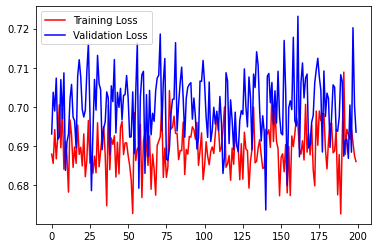

In [44]:
train(EPOCHS)

In [47]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader),total=len(testing_loader),position=0,leave=True):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets, loss

In [48]:
for epoch in range(1):
    outputs, targets, loss = validation(epoch)
    print(f'Loss : {loss}')
    score_list = []
    thresholds = np.arange(0.2,0.7,0.05)
    for limit in thresholds:
      outputs_bin = np.array(outputs) >= limit
      score_list.append(metrics.f1_score(targets, outputs_bin, average='macro'))
    limit_chosen = round(thresholds[np.argmax(score_list)], 2)
    print(f'With a threshold chosen as a score > {limit_chosen},')

    outputs = np.array(outputs) >= limit_chosen
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

Loss : 0.6981400847434998
With a threshold chosen as a score > 0.35,
Accuracy Score = 0.0
F1 Score (Micro) = 0.15827338129496402
F1 Score (Macro) = 0.133455496907054



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


## Résultats

### En gelant la dernière couche du modèle :

Le loss ne diminue pas, la partie BERT est trop spécialisée pour s'adapter à cette tâche.

Nb epochs|Threshold|Accuracy|F1 score (Micro)|F1 score (Macro)
---|--- |---|---|---
200|0.3|0%|0.16|0.13

### En réentrainant tout le modèle :

En voulant maximiser l'accuracy :

Nb epochs|Threshold|Accuracy|F1 score (Micro)|F1 score (Macro)
---|--- |---|---|---
50|0.3|25%|0.48|0.07


En voulant maximiser le score F1 (macro) :

Nb epochs|Threshold|Accuracy|F1 score (Micro)|F1 score (Macro)
---|--- |---|---|---
50|0.2|3.3%|0.44|0.11